#**TAREA TEXT MINING - DAVID GONZALO FERRER - CLASE 3 UCM**

Se realizan pequeñas modificaciones en las celdas propuestas para una mayor limpieza y organización

##0. Descarga de librerías necesarias

In [ ]:
pip install datasets
pip install evaluate
pip install fsspec==2023.9.2
pip install wordcloud
pip install ydata-profiling
pip install pandas nltk spacy matplotlib
python -m spacy download es_core_news_sm
pip install transformers datasets scikit-learn pandas


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.9/12.9 MB 78.0 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('es_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


## 1. Importación de librerías necesarias

In [ ]:
import numpy as np
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
import os
os.environ["WANDB_DISABLED"] = "true"
import re
import string
import pandas as pd
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
import spacy
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    classification_report,
    confusion_matrix
)
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    BertTokenizer,
    BertForSequenceClassification,
    TrainingArguments,
    Trainer,
    set_seed
)
from datasets import Dataset

## 2. Ejercicio1: Detección de profesiones en tweets

### Enunciado

En este ejercicio vamos a trabajar con un conjunto de datos procedente de medios sociales online.

Utilizaremos un subconjunto de los datos de la tarea 1 del shared task [**ProfNER**](https://temu.bsc.es/smm4h-spanish), centrada en la detección de menciones a profesiones en tweets publicados durante la pandemia del COVID-19. El objetivo original de la tarea era analizar que profesiones podrían haber sido especialmente vulnerables en el contexto de la crisis sanitaria.

Para simplificar el ejercicio, he preparado una versión reducida del dataset original. Tu tarea será entrenar un clasificador binario basado en la arquitectura Transformers, que, dado un tweet, determine si contiene una mención explícita a una profesión (etiqueta `1`) o no (etiqueta `0`).




✅ **Objetivos del ejercicio**

A lo largo de este notebook, completarás las siguientes etapas para construir un clasificador de menciones a profesiones en tweets:

1. **Análisis Exploratorio de Datos (EDA)**: Calcular estadísticas básicas del conjunto de datos (como el número de ejemplos del training set, la distribución de clases del dataset, la longitud media de los textos) o crear visualizaciones para cmprender mejor el contenido de los documentos usando wordclouds o histogramas.

2. **Selección y justificación del modelo**: Elegir un modelo del Hub de Huggingface adecuado para los datos con los que se va a trabajar y el tipo de tarea a desarrollar.

3. **Entrenamiento del clasificador**: Entrenar el modelo de forma reproducible y evaluar su rendimiento sobreel conjunto de datos de validación, incluyendo un classification score y matriz de confusion

4. **Generación de predicciones sobre el conjunte de test**: Aplicar el modelo entrenado al conjunto de test, y guardar las predicciones en un archivo `.tsv` de 2 columnas `id` y `label` separadas por tabulador

## 3. Obtención de datos

Descargamos los datos del [repositorio de Huggingface](https://huggingface.co/datasets/luisgasco/profner_classification_master).

In [ ]:
from datasets import load_dataset, Dataset, DatasetDict, ClassLabel
dataset = load_dataset("luisgasco/profner_classification_master")

El dataset contiene tres subsets:
- **train** y **validation**: Contienen el identificador del tweet, el texto, y su etiqueta, que podrá tener valor 1, si contiene una mención de una profesión; o valor 0, si no contiene una mención de una profesión.
- **test**: El test set tambiíen contiene la información de label por un requerimiento de Huggingface, pero el contenido de esta variable es siempre "-1". Es decir que deberéis predecir nuevas etiquetas una vez hayáis entrenado el modelo utilizando el train y el validation set.

## 4. Análisis exploratorio de datos

Para hacer el análisis exploratorio de datos, transformamos cada subset a un pandas dataframe para mayor comodidad.

In [ ]:
dataset_train_df = dataset["train"].to_pandas()
dataset_val_df = dataset["validation"].to_pandas()
dataset_test_df = dataset["test"].to_pandas()

In [ ]:

lista = [dataset_train_df, dataset_test_df]
nombres = ['dataset_train_df', 'dataset_test_df']

def get_num_docs_evaluation(lista):

  num_docs = [df.shape[0] for df in lista]
  print(f"El primer dataframe tiene {num_docs[0]} tweets")
  print(f"El segundo dataframe tiene {num_docs[1]} tweets")

### 4.1 Análisis exploratorio de los dataframe

In [ ]:
get_num_docs_evaluation(lista)

El primer dataframe tiene 2786 tweets
El segundo dataframe tiene 1001 tweets


Como se puede observar, vemos que el df de entrenamiento está compuesto por 2786 filas y el df de test por 1001 filas, lo que significa que se va a entrenar con aproximadamente el 73% de los datos.

### 4.2 Detección de outliers

In [ ]:
from scipy import stats

## Función para gestionar outliers
def gestiona_outliers(col,clas = 'check'):
     print(col.name)
     # Condición de asimetría y aplicación de criterio 1 según el caso
     if abs(col.skew()) < 1:
        criterio1 = abs((col-col.mean())/col.std())>3
     else:
        criterio1 = abs((col-col.median())/stats.median_abs_deviation(col))>6

     # Calcular primer cuartil
     q1 = col.quantile(0.25)
     # Calcular tercer cuartil
     q3 = col.quantile(0.75)
     # Calculo de IQR
     IQR=q3-q1
     # Calcular criterio 2 (general para cualquier asimetría)
     criterio2 = (col<(q1 - 3*IQR))|(col>(q3 + 3*IQR))
     lower = col[criterio1&criterio2&(col<q1)].count()/col.dropna().count()
     upper = col[criterio1&criterio2&(col>q3)].count()/col.dropna().count()
     # Salida según el tipo deseado
     if clas == 'check':
            return(lower*100,upper*100,(lower+upper)*100)
     elif clas == 'winsor':
            return(winsorize_with_pandas(col,(lower,upper)))
     elif clas == 'miss':
            print('\n MissingAntes: ' + str(col.isna().sum()))
            col.loc[criterio1&criterio2] = np.nan
            print('MissingDespues: ' + str(col.isna().sum()) +'\n')
            return(col)

In [ ]:
dataset_train_df.select_dtypes(include=np.number).apply(lambda x: gestiona_outliers(x))

label


,label
0,0.0
1,0.0
2,0.0


### 4.3 Análisis descriptivo de los dataframe

Se procede a realizar un análisis descriptivo de cada uno de los dataframe, train y test.

Para este análisis, utilizamos la librería de ProfileReport, que es una herramienta que permite realizar de forma rápida y automática un análisis exploratorio de datos (EDA), generando un informe que contiene estadísticas descriptivas básicas, distribuciones y gráficos, detección de valores faltantes y su proporción, y correlaciones entre variables entre otros puntos.

#### 4.3.1 Análisis descriptivo del dataset_train_df

In [ ]:
from ydata_profiling import ProfileReport

profile = ProfileReport(dataset_train_df, title="Reporte de Datos", explorative=True)
profile.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]


100%|██████████| 3/3 [00:00<00:00,  4.29it/s]


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Se procede a comentar detalladamente el informe obtenido por ProfileReport:

El conjunto de datos está compuesto por 2.786 observaciones y 3 variables, 1 numérica, 1 tipo texto y 1 categórica. No se registran celdas faltantes ni filas duplicadas, lo que indica que todos los registros son completos y únicos.

En cuanto a las variables, únicamente se analizará la variable de texto y la objetivo, puesto que el id no tiene sentido analizarlo.

  - Variable "text":
  Todos los valores de la variable son distintos, lo que indica que obviamente no se repiten los tweets. Asimismo, y como se ha comentado anteriormente, no hay valores perdidos. Esta variable, de la forma que lo ha expresado el reporte, revela que los términos más recurrentes son artículos y preposiciones - esto cambiará cuando se proceda a la limpieza del dataset -.


  - Variable "label":
  Esta columna es la variable objetivo, la cual es de tipo categórico, tomando únicamente dos valores (0 y 1), es decir, es una variable binaria. Asimismo, vemos que la proporción de valores es idéntica, lo que indica que las clases están balanceadas y no tendremos problemas a la hora de proponer modelos.

En cuanto a las correlaciones, no tiene cabida analizarlas puesto que no existen variables numéricas o categóricas que puedan correlacionarse con otras columnas.

Asimismo, con la visualización de las primeras filas del dataset, se puede observar que es preciso realzar una limpieza de dicho archivo, puesto que existen muchos caracteres especiales, url, y stopwords.

#### 4.3.2 Análisis descriptivo en detalle del dataset_train_df

Con el objetivo de conocer mejor los datos objeto de análisis, se procede a crear una columna para conocer el número de caracteres, la cual almacena la longitud de cada tweet. Esta métrica nos aporta información sobre cada uno de los tweets y posibles patrones que a simple vista no se verían.

Asimismo, nos ayuda a identificar valores atípicos, ya sean fragmentos vacíos o textos excesivamente largos.

Por último, la creación de este tipo de variables, puede ayudar a la capacidad predictiva de nuestro modelo.

##### 4.3.2.1 Número de caracteres

count    2786.000000
mean      215.057430
std        77.171112
min        10.000000
25%       152.000000
50%       235.000000
75%       282.000000
max       454.000000
Name: num_caracteres, dtype: float64


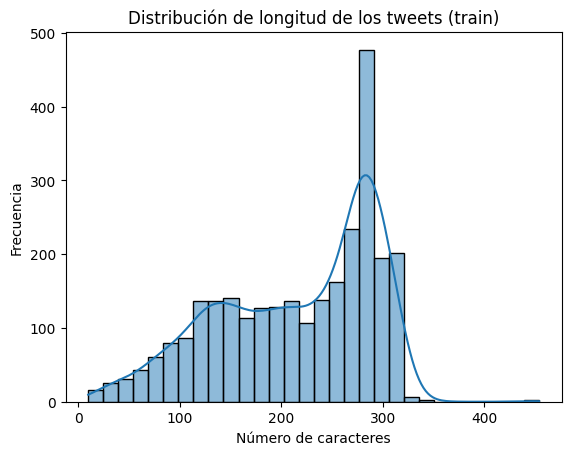

In [ ]:
dataset_train_df['num_caracteres'] = dataset_train_df['text'].str.len()

print(dataset_train_df['num_caracteres'].describe())

sns.histplot(dataset_train_df['num_caracteres'], bins=30, kde=True)
plt.title("Distribución de longitud de los tweets (train)")
plt.xlabel("Número de caracteres")
plt.ylabel("Frecuencia")
plt.show()


In [ ]:
dataset_train_df['num_caracteres'].skew()

np.float64(-0.5531451069962536)

La distribución de esta primera nueva variable muestra que la media de los tweets es aproximadamente 215 caracteres, lo que significa que la mayoría de registros de este dataset se acercan al número máximo permitido por la aplicación -antiguo Twitter/nuevo X-.

Asimismo, es interesante estudiar el máximo de los tweets, que es de 454 caracteres, lo que nos puede chocar respecto al número máximo de caracteres permitido por la aplicación (280), esto debe ser porque a parte del tweet se incluye la url del tweet.

Muy relacionado con lo anterior, es lo que se observa en el histograma de la variable y su asimetría, puesto que existe una asimetría negativa lo que indica que la cola de la distribución de se extiende hacia la izquierda, es decir, hay más tweets con longitud ligeramente superior a la media que con longitud muy corta.

Respecto a la curtosis, es importante saber que es positiva, ya que el pico central es más pronunciado que en una distribución normal y las colas son relativamente pesadas, es decir, hay mayor probabilidad de valores alejados de la media, pudiendo encontrar potenciales outliers.

###### 4.3.2.1.1 Agrupación del número de caracteres

Se crea una nueva variable llamada num_caracteres_tramo, con el objetivo de clasificar los valores de dicha columna en tramos o rangos específicos, con el objetivo de ayudar a la capacidad predictiva del modelo.

In [ ]:
print(dataset_train_df['num_caracteres'].min())
print(dataset_train_df['num_caracteres'].max())

10
454


In [ ]:
dataset_train_df['num_caracteres_tramo'] = pd.cut(
    dataset_train_df['num_caracteres'],
    bins=[50, 250, np.inf],
    labels=[0,1]
)

In [ ]:
dataset_train_df['num_caracteres_tramo'].value_counts(normalize = True)

,proportion
num_caracteres_tramo,
0,0.544718
1,0.455282


##### 4.3.2.2 Número de palabras

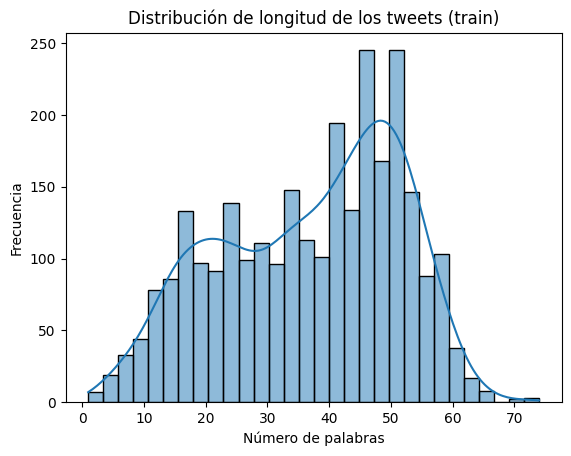

In [ ]:
dataset_train_df['num_palabras'] = dataset_train_df['text'].str.split().str.len()

sns.histplot(dataset_train_df['num_palabras'], bins=30, kde=True)
plt.title("Distribución de longitud de los tweets (train)")
plt.xlabel("Número de palabras")
plt.ylabel("Frecuencia")
plt.show()

La distribución de esta nueva variable muestra que la media de palabras por tweet es de aproximadamente 45, lo que indica que la mayoría de registros contienen una densidad de texto considerable en relación con el límite de caracteres de la plataforma.

Asimismo, se observa en el histograma de la variable una asimetría negativa, lo que indica que hay más tweets con un número elevado de palabras (cola derecha) y una cola izquierda más alargada hacia valores bajos, es decir, existen pocos tweets relativamente muy cortos.

Respecto a la curtosis, esta es positiva, pues el pico central es más pronunciado que en una distribución normal y las colas son relativamente pesadas, lo que sugiere una mayor probabilidad de encontrar registros alejados de la media y, por tanto, posibles outliers.

In [ ]:
dataset_train_df['num_palabras'].skew()

np.float64(-0.32025864700651996)

##### 4.3.2.2.1 Agrupación del número de palabras

Al igual que se ha realizado anteriormente, se crea una nueva variable con el objetivo de clasificar los valores de dicha columna en tramos o rangos específicos, con el objetivo de ayudar a la capacidad predictiva del modelo.

In [ ]:
print(dataset_train_df['num_palabras'].min())
print(dataset_train_df['num_palabras'].max())

1
74


In [ ]:
dataset_train_df['num_palabras_tramo'] = pd.cut(
    dataset_train_df['num_palabras'],
    bins=[15, 40, np.inf],
    labels=[0,1]
)

In [ ]:
dataset_train_df['num_palabras_tramo'].value_counts(normalize=True)

,proportion
num_palabras_tramo,
1,0.530766
0,0.469234


#### 4.3.2.3 Relación entre caracteres y palabras

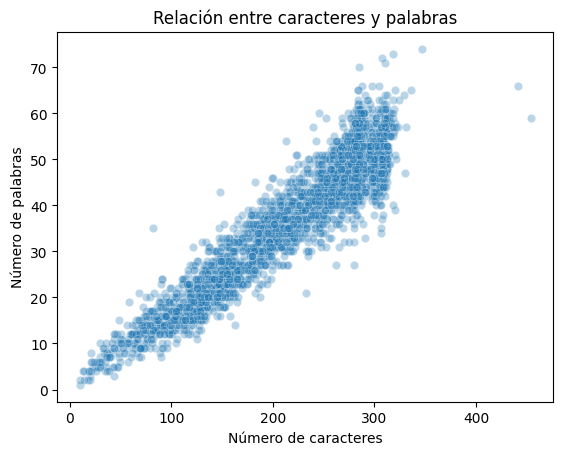

In [ ]:
sns.scatterplot(data=dataset_train_df, x='num_caracteres', y='num_palabras', alpha=0.3)
plt.title('Relación entre caracteres y palabras')
plt.xlabel('Número de caracteres')
plt.ylabel('Número de palabras')
plt.show()

Se realiza un diagrama de dispersión que muestra una relación lineal positiva entre el número de caracteres y el número de palabras de cada tweet. A medida que aumenta la longitud en caracteres, también lo hace la cantidad de palabras, lo cual tiene sentido porque tweets más largos suelen incluir más términos.

Sin embargo, hay ciertos puntos que no están correlacionados debido a que se incluyen emoticonos y url entre otros.

#### 4.3.2.4 Boxplot

<ipython-input-69-2648809598>:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=dataset_train_df, x='label', y='num_palabras', palette='Set2')


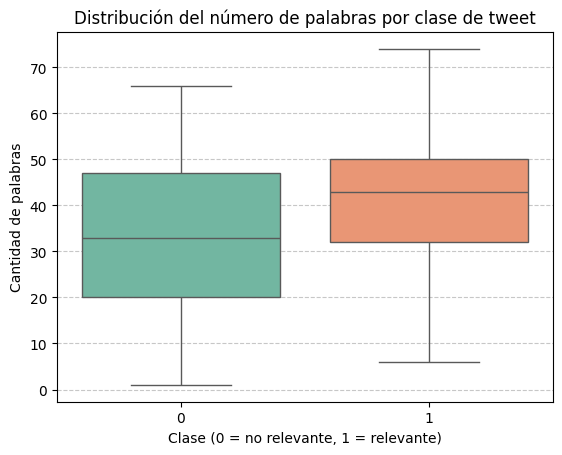

In [ ]:
sns.boxplot(data=dataset_train_df, x='label', y='num_palabras', palette='Set2')
plt.title('Distribución del número de palabras por clase de tweet')
plt.xlabel('Clase (0 = no relevante, 1 = relevante)')
plt.ylabel('Cantidad de palabras')
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.show()

Se procede a realizar un boxplot con el objetivo de comparar la longitud de los tweets entre las dos clases de la variable objetivo.

En esta visualización se observa que los tweets etiquetados como relevantes suelen ser más extensos pero existe solapamiento en ambas distribuciones, ya que hay ejemplos de tweets cortos en la clase relevante y tweets largos en la clase no relevante.


#### 4.3.2.5 Función automatizada

Se utiliza una función automatizada de Soledad Galli para poder obtener de forma rápida, los gráficos de caja, probabilidad e histograma.



In [ ]:
from scipy import stats

def diagnostic_plots(df, variable):
    # function takes a dataframe (df) and
    # the variable of interest as arguments

    # define figure size
    plt.figure(figsize=(16, 4))

    # histogram
    plt.subplot(1, 3, 1)
    sns.distplot(df[variable], bins=30)
    plt.title(f'Histogram - {variable}')

    # Q-Q plot
    plt.subplot(1, 3, 2)
    stats.probplot(df[variable], dist="norm", plot=plt)
    plt.ylabel(f'Q-Q Plot - {variable}')

    # boxplot
    plt.subplot(1, 3, 3)
    sns.boxplot(y=df[variable])
    plt.title(f'Boxplot - {variable}')

    plt.show()

In [ ]:
lista2 = [dataset_train_df['label'] == '0', dataset_train_df['label'] == '1']


DataFrame #1 (label = '0')

Diagnóstico para: label


<ipython-input-70-2122778001>:12: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[variable], bins=30)
/usr/local/lib/python3.11/dist-packages/seaborn/distributions.py:2496: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  kdeplot(**{axis: a}, ax=ax, color=kde_color, **kde_kws)


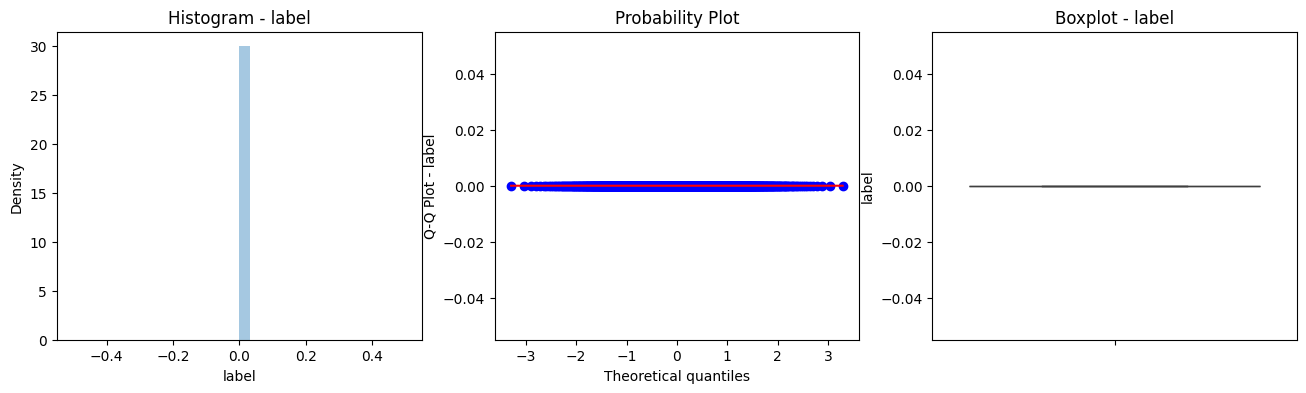


Diagnóstico para: num_caracteres


<ipython-input-70-2122778001>:12: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[variable], bins=30)


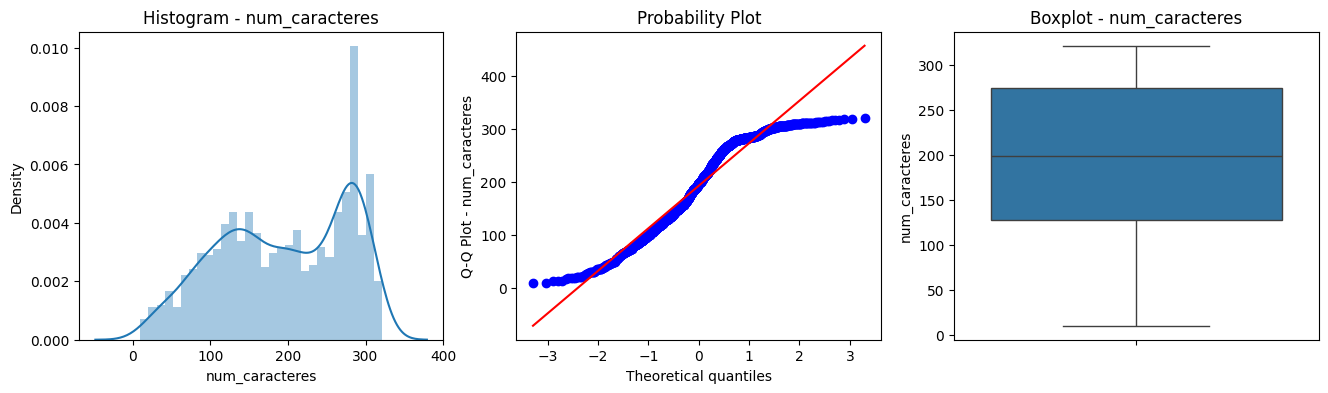


Diagnóstico para: num_palabras


<ipython-input-70-2122778001>:12: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[variable], bins=30)


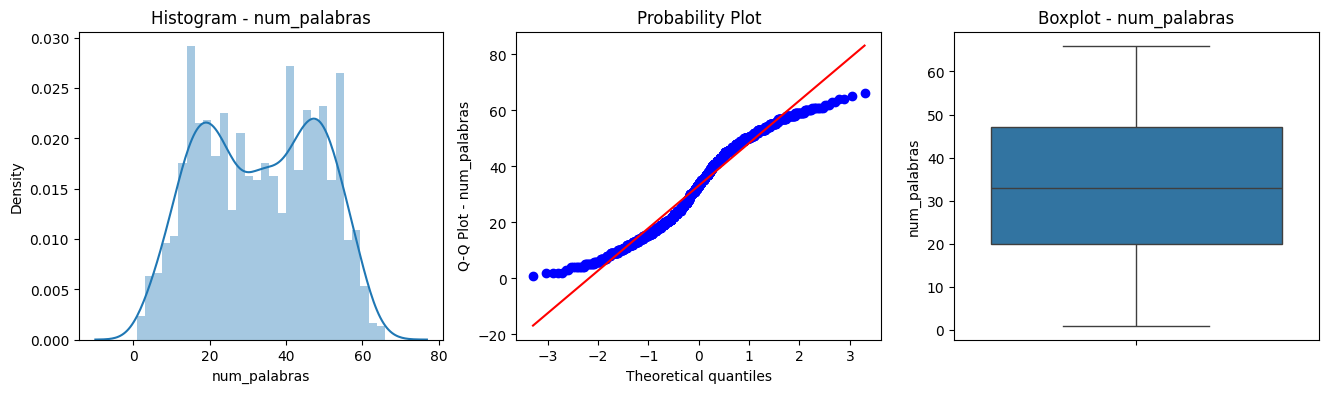


DataFrame #2 (label = '1')

Diagnóstico para: label


<ipython-input-70-2122778001>:12: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[variable], bins=30)
/usr/local/lib/python3.11/dist-packages/seaborn/distributions.py:2496: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  kdeplot(**{axis: a}, ax=ax, color=kde_color, **kde_kws)


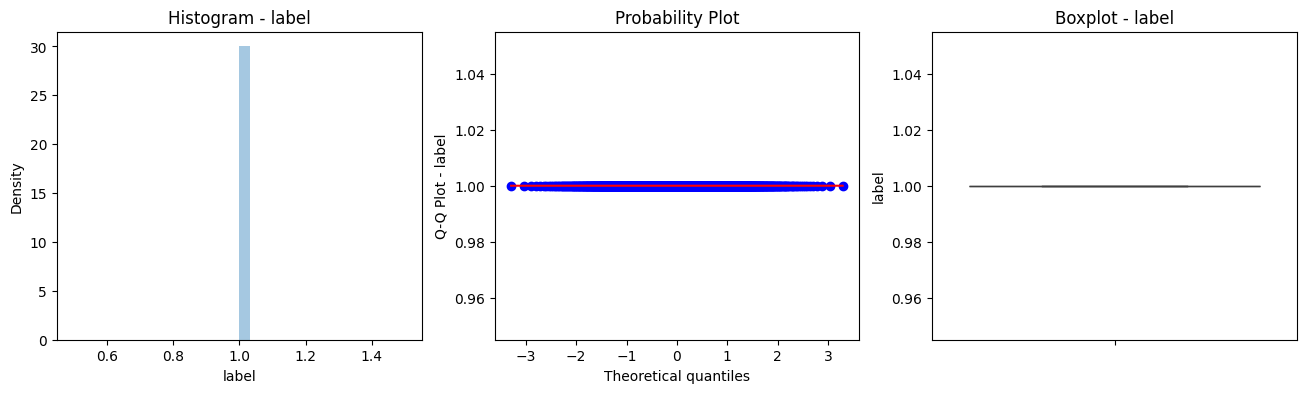


Diagnóstico para: num_caracteres


<ipython-input-70-2122778001>:12: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[variable], bins=30)


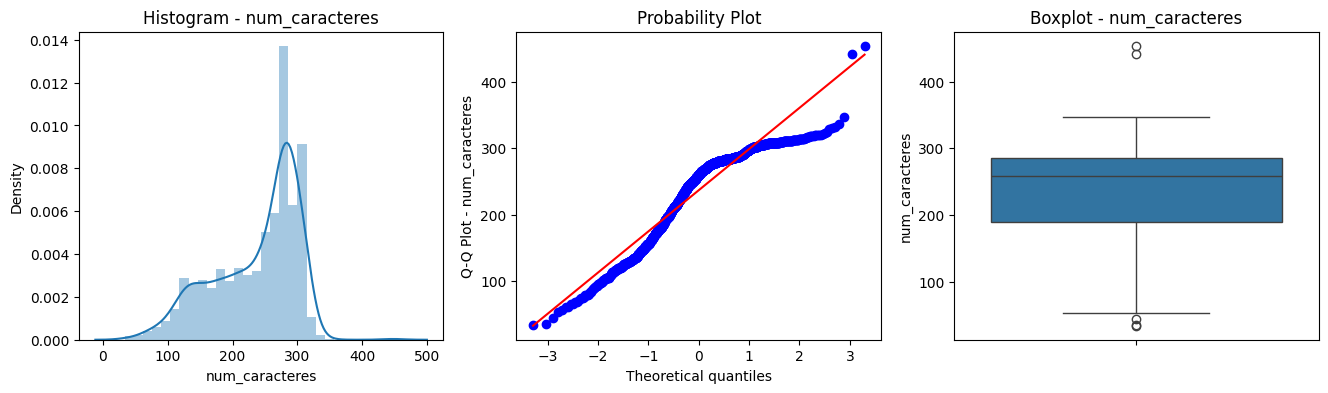


Diagnóstico para: num_palabras


<ipython-input-70-2122778001>:12: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[variable], bins=30)


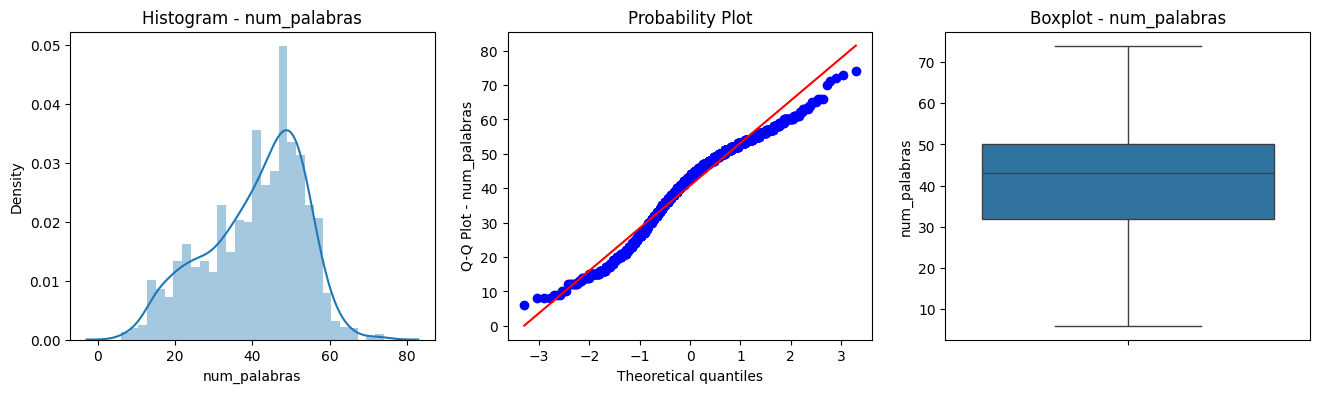

In [ ]:
# Posibles valores de las etiquetas del dataset
etiquetas = [0, 1]

# Se crea un dataframe por cada posible valor
dfs_filtrados = [
    dataset_train_df[dataset_train_df['label'] == etiqueta]
    for etiqueta in etiquetas
]

for i, (etiqueta, df) in enumerate(zip(etiquetas, dfs_filtrados), start=1):
    # Condición para manejar errores
    if df.empty:
        print(f"\nDataFrame #{i} para label = '{etiqueta}' está vacío; lo salto.")
        continue

    print(f"\nDataFrame #{i} (label = '{etiqueta}')")

    # Se aplica la función a aquellas columnas numéricas
    for var in df.select_dtypes(include='number').columns:
        print(f"\nDiagnóstico para: {var}")
        diagnostic_plots(df, var)

## 5. Número de documentos duplicados

A continuación, se utiliza la función `detect_duplicates_evaluation()` para obtener la cantidad de documentos duplicados presentes tanto en el conjunto de entrenamiento (`training`) como en el de validación (`validation`).


In [ ]:
def detect_duplicates_evaluation(lista):
  num_duplicates = sum(df.duplicated().sum() for df in lista)
  return num_duplicates

In [ ]:
detect_duplicates_evaluation(lista)

np.int64(0)

## 6. Número de documentos por cada clase

A continuación, se utiliza la función `analyse_num_labels_evaluation()` para calcular el número de documentos de cada categoría en el dataset

In [ ]:
def analyse_num_labels_evaluation(dataset_df):
  num_positives = (dataset_df['label'] == 1).sum()
  num_negatives = (dataset_df['label'] == 0).sum()
  return num_positives, num_negatives

Una vez generada la función, puedes utilizarla posteriormente para calcular resultados y comentarlos

In [ ]:
for nombre, df in zip(nombres, lista):
    pos, neg = analyse_num_labels_evaluation(df)
    print(f"{nombre} → Positivos: {pos}, Negativos: {neg}")

dataset_train_df → Positivos: 1393, Negativos: 1393
dataset_test_df → Positivos: 0, Negativos: 0


## 7. Distribución de la longitud de los tweet en caracteres

Se procede a realizar varios wordcloud antes de la tokenización según la variable objetivo sea 1 o 0, con el objetivo de ver posibles patrones según sea de un tipo u otro.

### 7.1 Distribución de la longitud de los tweet en caracteres cuando label == 0

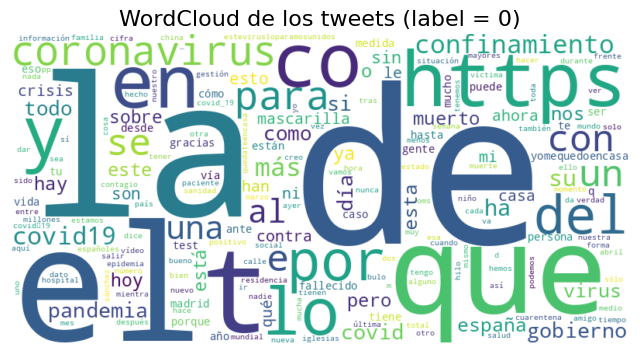

In [ ]:
texto_completo = " ".join(
    dataset_train_df[dataset_train_df['label'] == 0]['text']
    .dropna()
    .astype(str)
    .str.lower()
)

wc = WordCloud(
    width=800,
    height=400,
    background_color="white",
    collocations=False
).generate(texto_completo)

plt.figure(figsize=(8, 6))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.title("WordCloud de los tweets (label = 0)", fontsize=16)
plt.show()

Como se puede observar en este wordcloud, cuando el valor de la variable objetivo es 0, la mayoría de palabras que se repiten son artículos, preposiciones y texto especial relacionado con la url de los tweets como "https". Este wordcloud no nos aporta mucha información, por lo que tendremos tokenizar para extraer mayor información.

### 7.2 Distribución de la longitud de los tweet en caracteres cuando label == 1

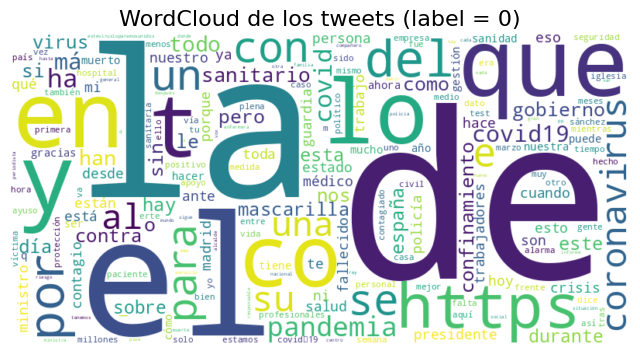

In [ ]:
texto_completo = " ".join(
    dataset_train_df[dataset_train_df['label'] == 1]['text']
    .dropna()
    .astype(str)
    .str.lower()
)

wc = WordCloud(
    width=800,
    height=400,
    background_color="white",
    collocations=False
).generate(texto_completo)

plt.figure(figsize=(8, 6))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.title("WordCloud de los tweets (label = 0)", fontsize=16)
plt.show()

Al igual que hemos visto en la imagen anterior, este wordcloud tampoco nos aporta una información clave, por lo que se procede en el siguiente epígrafe a tokenizar.

### 7.3 Gráfico top 10 palabras más usadas pre-tokenización

Se procede a realizar un conteo de las palabras más utilizadas en el dataframe de entrenamiento con el fin de demostrar lo anteriormente comentado, es decir, que se precisa tokenización para obtener información clave.

In [ ]:
palabras = " ".join(dataset_train_df['text'].dropna().astype(str)).lower().split()

conteo_palabras = Counter(palabras)
print(conteo_palabras.most_common(10))

[('de', 4805), ('.', 3334), ('la', 3090), (',', 3035), ('el', 2545), ('que', 2356), ('#', 2312), ('en', 2186), ('y', 2149), ('a', 2106)]


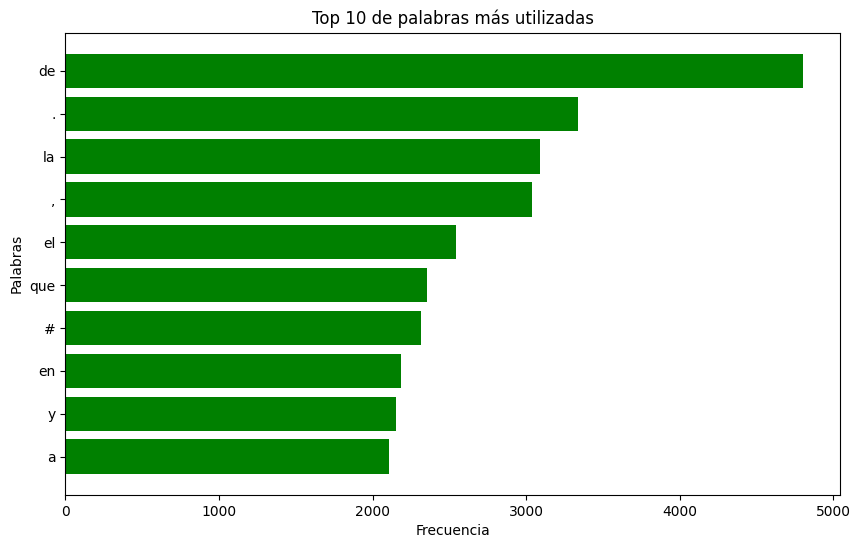

In [ ]:
top_10 = conteo_palabras.most_common(10)

# Se divide cada palabra con el número de veces que se repite
palabras_top = [item[0] for item in top_10]
frecuencias_top = [item[1] for item in top_10]

# Se elabora el gráfico del conteo de las palabras más utilizadas
plt.figure(figsize=(10, 6))
plt.barh(palabras_top, frecuencias_top, color='green')
plt.xlabel('Frecuencia')
plt.ylabel('Palabras')
plt.title('Top 10 de palabras más utilizadas')
plt.gca().invert_yaxis()
plt.show()

## 8. Tokenización

In [ ]:
stopwords_es = set(stopwords.words('spanish'))

def tokenize_text(text):
    if isinstance(text, str):
        tokens = re.findall(r'\w+', text.lower())
        return [token for token in tokens if token not in stopwords_es]
    return []

dataset_train_df['tokens'] = dataset_train_df['text'].apply(tokenize_text)

dataset_train_df[['text', 'tokens']].head()

,text,tokens
0,Las / os sanitarias / os no necesitan capas de...,"[sanitarias, necesitan, capas, superhéroes, su..."
1,Las residencias de mayores de Burgos suman 42 ...,"[residencias, mayores, burgos, suman, 42, fall..."
2,@IreneMontero Utilice el tiempo de confinamien...,"[irenemontero, utilice, tiempo, confinamiento,..."
3,.@FreseniusKabi dona más de 110.000 mascarilla...,"[freseniuskabi, dona, 110, 000, mascarillas, g..."
4,Judy y el confinamiento . Dia 31 . Mona de Pas...,"[judy, confinamiento, dia, 31, mona, pascua, h..."


Se procede a tokenizar, el cual es el proceso de convertir un texto en unidades más básicas llamadas tokens, con el objetivo de transformar estas palabras y utilizarlas en los siguientes modelos.


## 9. Gráfico wordcloud después de tokenización

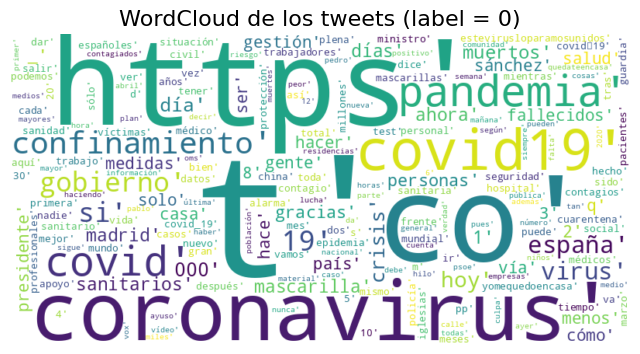

In [ ]:
texto_completo = " ".join(
    dataset_train_df['tokens']
    .dropna()
    .astype(str)
    .str.lower()
)

wc = WordCloud(
    width=800,
    height=400,
    background_color="white",
    collocations=False
).generate(texto_completo)

plt.figure(figsize=(8, 6))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.title("WordCloud de los tweets (label = 0)", fontsize=16)
plt.show()

Como se puede observar, la tokenización nos ha servido para eliminar palabras como artículos y preposiciones que no nos aportan valor para nuestros modelos, pero aún así siguen habiendo palabras relacionadas con las url de los tweets que debemos limpiar para que nuestros modelos funcionen y obtener métricas correctas.

## 10. Gráfico top 10 palabras más usadas después de tokenización

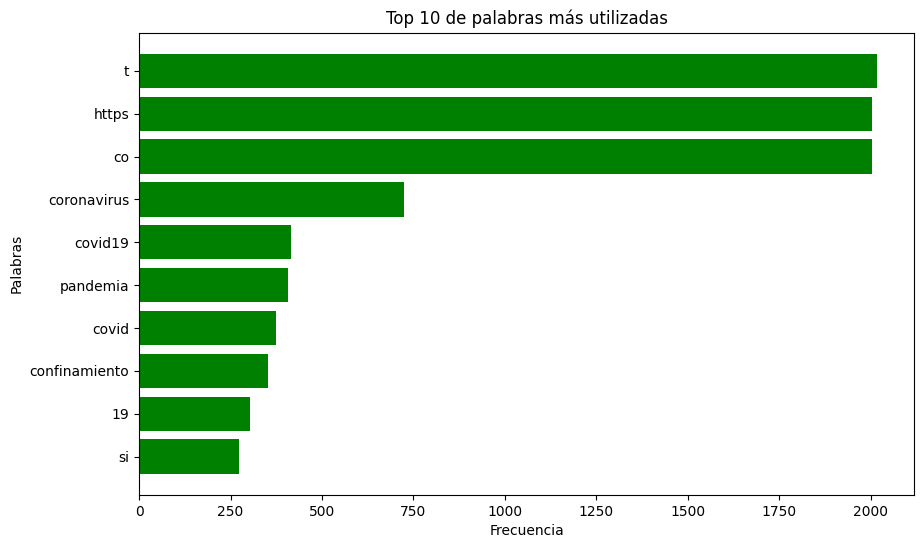

In [ ]:
todos_los_tokens = [token for sublista in dataset_train_df['tokens'] for token in sublista]

conteo = Counter(todos_los_tokens)
top_10 = conteo.most_common(10)

palabras_top = [item[0] for item in top_10]
frecuencias_top = [item[1] for item in top_10]

plt.figure(figsize=(10, 6))
plt.barh(palabras_top, frecuencias_top, color='green')
plt.xlabel('Frecuencia')
plt.ylabel('Palabras')
plt.title('Top 10 de palabras más utilizadas')
plt.gca().invert_yaxis()
plt.show()

## 11. Gráfico top 10 palabras más utilizadas con limpieza profunda

Se procede a realizar una tokenización más profunda con el objetivo de preparar los datos antes de entrenar modelos de lenguaje propuestos.

Para ello, utilizamos un código propuesto por la IA que descarga las stopwords en español usando NLTK y carga el modelo lingüístico de spaCy.

Posteriormente, se convierte el texto a minúsculas, eliminando url, menciones, hashtags, números, y signos de puntuación, para finalmente aplicar la lematización y obtener una columna con los tokens procesados.


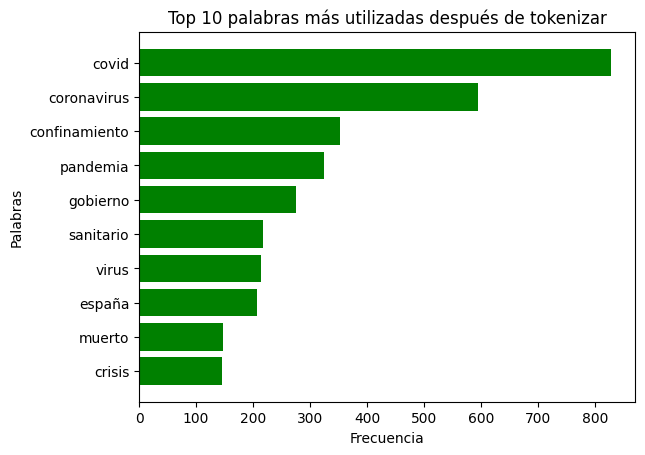

In [ ]:
nlp = spacy.load("es_core_news_sm")

stop_words = set(stopwords.words('spanish'))

def limpiar_texto(texto):
    if pd.isnull(texto):
        return []

    # Se pasa el texto a minúsculas
    texto = texto.lower()

    # Se eliminan las URL
    texto = re.sub(r'http\S+|www\S+|https\S+', '', texto)

    # Se eliminan las menciones y hashtags
    texto = re.sub(r'@\w+|#\w+', '', texto)

    # Se eliminan los números y puntuación
    texto = re.sub(r'\d+', '', texto)
    texto = texto.translate(str.maketrans('', '', string.punctuation))

    # Se vuelve a tokenizar
    tokens = texto.split()

    # Se filtran los tokens cortos y stopwords
    tokens = [word for word in tokens if len(word) > 2 and word not in stop_words]

    # Se lemantiza con spaCy
    doc = nlp(" ".join(tokens))
    tokens_limpios = [token.lemma_ for token in doc if not token.is_stop and not token.is_punct]

    return tokens_limpios

# Se aplica la limpieza
dataset_train_df['tokens_limpios'] = dataset_train_df['text'].apply(limpiar_texto)

from collections import Counter
all_tokens = sum(dataset_train_df['tokens_limpios'], [])
frecuencia = Counter(all_tokens)
top_10 = frecuencia.most_common(10)


palabras, conteos = zip(*top_10)
plt.barh(palabras[::-1], conteos[::-1], color='green')
plt.xlabel("Frecuencia")
plt.ylabel("Palabras")
plt.title("Top 10 palabras más utilizadas después de tokenizar")
plt.show()

## 12. MODELOS PROPUESTOS

Se procede a definir varias funciones para optimizar el rendimiento computacional y se proponen 3 modelos distintos.

In [ ]:
# Reproducibilidad
set_seed(42)

# 1. Preparar datos
def prepare_data(df):
    texts = df["text"].tolist()
    labels = df["label"].tolist()
    return train_test_split(texts, labels, test_size=0.2, random_state=42)

# 2. Tokenizar
from transformers import AutoTokenizer

def tokenize_texts(train_texts, val_texts, tokenizer_name):
    tokenizer = AutoTokenizer.from_pretrained(tokenizer_name)
    train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=128)
    val_encodings = tokenizer(val_texts, truncation=True, padding=True, max_length=128)
    return tokenizer, train_encodings, val_encodings


# 3. Dataset personalizado
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item["labels"] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

# 4. Cargar modelo
def load_model(model_name, num_labels):
    return AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=num_labels)

# 5. Argumentos de entrenamiento
def get_training_args(output_dir="./model", epochs=3, batch_size=8, logging_dir="./logs"):
    return TrainingArguments(
        output_dir=output_dir,
        num_train_epochs=epochs,
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,
        logging_dir=logging_dir,
        logging_steps=10
    )


# 6. Métricas personalizadas
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = torch.argmax(torch.tensor(logits), axis=1).numpy()
    return {
        "accuracy": accuracy_score(labels, preds),
        "f1": f1_score(labels, preds, average='macro')
    }

# 7. Crear entrenador
def create_trainer(model, training_args, train_dataset, val_dataset):
    return Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        compute_metrics=compute_metrics
    )

# 8. Entrenamiento y predicción
def train_and_evaluate(trainer):
    trainer.train()
    preds_output = trainer.predict(trainer.eval_dataset)
    preds = torch.argmax(torch.tensor(preds_output.predictions), axis=1).numpy()
    return preds

# 9. Mostrar métricas
def print_metrics(true_labels, preds):
    print("Accuracy:", accuracy_score(true_labels, preds))
    print("F1 macro:", f1_score(true_labels, preds, average='macro'))
    print("\nClassification Report:\n", classification_report(true_labels, preds))

# 10. Matriz de confusión
def plot_confusion_matrix(true_labels, preds):
    cm = confusion_matrix(true_labels, preds)
    labels = sorted(list(set(true_labels)))
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

### 12.1 MODELO BETO (BERT)

El primer modelo que se propone es el BERT, basado en BETO, el cual es una adaptación de dicho modelo, entrenado con datos en español para tareas de NLP.

Se ha optado en primer lugar por este modelo ya que se ha preentrenado exclusivamente en español, utilizando todo tipo de textos, permitiéndole capturar mejor que otros modelos.

En cuanto a las métricas indican que el clasificador BETO rinde de forma sólida y equilibrada, consiguiendo una exactitud del 94 %, lo que significa que casi todas las instancias del conjunto de validación se etiquetan correctamente, y un F1 macro de 0,94, que confirma un tratamiento homogéneo de ambas clases sin sesgos por desequilibrio.

En el detalle de dichas métricas, se observa que la clase 0 presenta una precisión del 96 % y un recall del 94 %, es decir, rara vez confunde ejemplos de esta clase. Por otro lado, la clase 1 muestra un recall ligeramente mayor 95 % y una precisión algo menor 93 %, recuperando casi todos los casos positivos pero aceptando algunos falsos positivos más.

En conjunto, el modelo mantiene un balance casi simétrico entre ambas clases y proporciona un rendimiento bastante alto.




Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-cased and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Step,Training Loss
10,0.728800
20,0.773800
30,0.674100
40,0.603800
50,0.680100
60,0.658900
70,0.628100
80,0.567800
90,0.644300
100,0.503700


 Modelo BETO BERT
Accuracy: 0.9444444444444444
F1 macro: 0.9441717256804252

Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.94      0.95       301
           1       0.93      0.95      0.94       257

    accuracy                           0.94       558
   macro avg       0.94      0.94      0.94       558
weighted avg       0.94      0.94      0.94       558



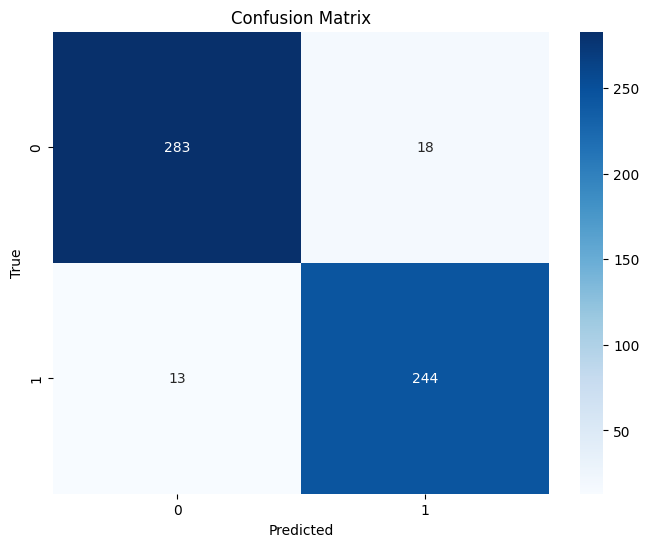

In [ ]:
# Se define el modelo a utilizar
model_name = "dccuchile/bert-base-spanish-wwm-cased"

# Preparación de los datos
train_texts, val_texts, train_labels, val_labels = prepare_data(dataset_train_df)

# Tokenización de los textos con mBERT
tokenizer, train_encodings, val_encodings = tokenize_texts(
    train_texts, val_texts, tokenizer_name=model_name
)

# Argumentos de entrenamiento
train_dataset = CustomDataset(train_encodings, train_labels)
val_dataset = CustomDataset(val_encodings, val_labels)

# Se carga el modelo mBERT para clasificación
model = load_model(model_name, num_labels=len(set(train_labels)))

# Argumentos de entrenamiento
training_args = get_training_args(
    output_dir="./beto_model",
    epochs=3,
    batch_size=8,
    logging_dir="./logs"
)

# Se crea el entrenador
trainer = create_trainer(model, training_args, train_dataset, val_dataset)

# Se entrena el modelo
preds = train_and_evaluate(trainer)

# Se obtienen las métricas
print(" Modelo BETO BERT")
print_metrics(val_labels, preds)

# Se crea una matriz de confusión
plot_confusion_matrix(val_labels, preds)

### 12.2 MULTILINGUAL BERT

El segundo modelo evaluado es Multilingual BERT, una versión del modelo anterior preentrenada en más idiomas. Este modelo entrenado en múltiples lenguas y vocabulario unificado, no se ha ajustado de forma específica al español, en consecuencia, cabe esperar que dicho modelo no sea tan preciso como el anterior.

Las métricas confirman esta limitación, debido a que el clasificador alcanza apenas una exactitud del 46 % y un F1 macro de 0,32, valores que señalan un rendimiento global bajo y, sobre todo, muy desequilibrado. En cuanto al detalle, la clase 0 tiene una precisión y recall nulos, lo que implica que el modelo no reconoce los ejemplos de esta categoría; en cambio, la clase 1 obtiene un recall perfecto pero una precisión baja (46 %), lo que se traduce en una gran cantidad de falsos positivos.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Step,Training Loss
10,0.767800
20,0.751700
30,0.728400
40,0.722900
50,0.707900
60,0.719800
70,0.712100
80,0.691200
90,0.700400
100,0.732400


Modelo Multilingual BERT
Accuracy: 0.460573476702509
F1 macro: 0.31533742331288345

Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00       301
           1       0.46      1.00      0.63       257

    accuracy                           0.46       558
   macro avg       0.23      0.50      0.32       558
weighted avg       0.21      0.46      0.29       558



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


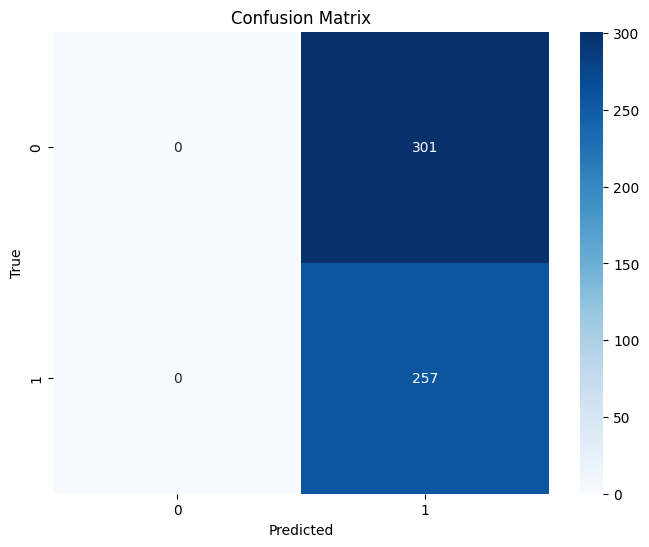

In [ ]:
# Se define el modelo a utilizar
model_name = "bert-base-multilingual-cased"

# Preparación de los datos
train_texts, val_texts, train_labels, val_labels = prepare_data(dataset_train_df)

# Tokenización de los textos con mBERT
tokenizer, train_encodings, val_encodings = tokenize_texts(
    train_texts, val_texts, tokenizer_name=model_name
)

# Se crean los datasets con los textos tokenizados
train_dataset = CustomDataset(train_encodings, train_labels)
val_dataset = CustomDataset(val_encodings, val_labels)

# Se carga el modelo mBERT para clasificación
model = load_model(model_name, num_labels=len(set(train_labels)))

# Argumentos de entrenamiento
training_args = get_training_args(
    output_dir="./mbert_model",
    epochs=3,
    batch_size=8,
    logging_dir="./logs"
)

# Se crea el entrenador
trainer = create_trainer(model, training_args, train_dataset, val_dataset)

# Función auxiliar para entrenar y evaluar
def train_and_evaluate(trainer):
    trainer.train()
    predictions = trainer.predict(trainer.eval_dataset)
    preds = torch.argmax(torch.tensor(predictions.predictions), axis=1).numpy()
    return preds

# Función para imprimir métricas
def print_metrics(true_labels, preds):
    print("Accuracy:", accuracy_score(true_labels, preds))
    print("F1 macro:", f1_score(true_labels, preds, average='macro'))
    print("\nClassification Report:\n", classification_report(true_labels, preds))

# Se entrena el modelo
preds = train_and_evaluate(trainer)

# Se obtienen las métricas
print("Modelo Multilingual BERT")
print_metrics(val_labels, preds)

# Se crea una matriz de confusión
plot_confusion_matrix(val_labels, preds)

### 12.3 MODELO RoBERTuito

El tercer modelo propuesto es RoBERTuito, una variante de RoBERTa entrenada específicamente con grandes volúmenes de tweets en español, lo que aporta gran sensibilidad para captar el vocabulario coloquial, abreviaturas y giros idiomáticos propios de las redes sociales.

Se ha seleccionado este modelo porque al estar entrenado con este tipo de mensajes y lenguaje, le permite reconocer matices afectivos y expresiones que otros modelos pasan por alto.

En cuanto a las métricas, el clasificador rinde de forma muy sólida y equilibrada, consiguiendo una exactitud del 96 %, lo que significa que prácticamente todas los datos del conjunto de validación se etiquetan correctamente, y un F1 macro de 0,96, que confirma un tratamiento homogéneo de ambas clases sin sesgos.

En el detalle de dichas métricas, se observa que la clase 0 presenta una precisión del 97 % y un recall del 96 %, de modo que rara vez confunde ejemplos de esta clase. Por otro lado, la clase 1 muestra un recall ligeramente mayor y una precisión algo menor, recuperando casi todos los casos positivos pero aceptando algunos falsos positivos más.

En conjunto, el modelo mantiene un balance casi simétrico entre ambas clases y ofrece un rendimiento muy alto, superando ligeramente a los anteriores modelos propuestos.











Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at pysentimiento/robertuito-base-uncased and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Step,Training Loss
10,0.764900
20,0.754400
30,0.627700
40,0.568000
50,0.573700
60,0.498100
70,0.513500
80,0.409600
90,0.486300
100,0.392200


Modelo RoBERTuito
Accuracy: 0.9623655913978495
F1 macro: 0.9621613068847822

Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.96      0.96       301
           1       0.95      0.96      0.96       257

    accuracy                           0.96       558
   macro avg       0.96      0.96      0.96       558
weighted avg       0.96      0.96      0.96       558



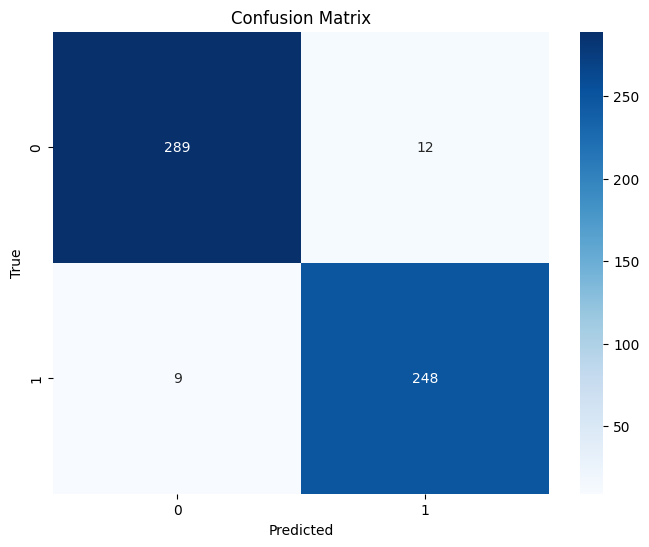

In [ ]:
# Se define el modelo a utilizar
model_name = "pysentimiento/robertuito-base-uncased"

# Preparación de los datos
train_texts, val_texts, train_labels, val_labels = prepare_data(dataset_train_df)

# Tokenización de los textos con RoBERTuito
tokenizer, train_encodings, val_encodings = tokenize_texts(
    train_texts, val_texts, tokenizer_name=model_name
)

# Argumentos de entrenamiento
train_dataset = CustomDataset(train_encodings, train_labels)
val_dataset = CustomDataset(val_encodings, val_labels)

# Se carga el modelo RoBERTuito para clasificación
model = load_model(model_name, num_labels=len(set(train_labels)))

# Argumentos de entrenamiento
training_args = get_training_args(
    output_dir="./robertuito_model",
    epochs=3,
    batch_size=8,
    logging_dir="./logs"
)

# Se crea el entrenador
trainer = create_trainer(model, training_args, train_dataset, val_dataset)

# Se entrena el modelo
preds = train_and_evaluate(trainer)

# Se obtienen las métricas
print("Modelo RoBERTuito")
print_metrics(val_labels, preds)

# Se crea una matriz de confusión
plot_confusion_matrix(val_labels, preds)

Tras el análisis realizado, se decide escoger el modelo de ROBERTuito debido a que alcanza la mayor exactitud global respecto a los otros modelos, presentando un F1 muy alto, lo que aporta equilibrio entre el resto de métricas.

Uno de los motivos por los que este modelo funciona tan bien es debido a que
capta matices lingüísticos que los otros modelos no son capaces de capturar.


## 13. APLICACIÓN TRANSFORMACIONES AL DATASET DE TEST Y GENERACIÓN DE PREDICCIONES

Se realizan las mismas transformaciones que se han hecho en train a test, y se aplica el mejor modelo obtenido anteriormente.

In [ ]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels=None):
        self.encodings = encodings
        self.labels = labels
    def __len__(self): return len(self.encodings["input_ids"])
    def __getitem__(self, idx):
        item = {k: torch.tensor(v[idx]) for k,v in self.encodings.items()}
        if self.labels is not None:
            item["labels"] = torch.tensor(self.labels[idx])
        return item

# Se prepocesa test al igual que train
df_test = dataset_test_df.copy()
df_test["num_palabras"]   = df_test["text"].str.split().str.len()
df_test["num_caracteres"] = df_test["text"].str.len()
df_test["num_caracteres_tramo"] = pd.cut(df_test["num_caracteres"], [50,250,float("inf")], labels=[0,1])
df_test["num_palabras_tramo"]   = pd.cut(df_test["num_palabras"],   [15,40,float("inf")],  labels=[0,1])
df_test["tokens"] = df_test["text"].apply(tokenize_text)

# Se tokeniza
enc = tokenizer(df_test["text"].tolist(),
                truncation=True, padding=True, max_length=128)

test_dataset = CustomDataset(enc)
test_logits  = trainer.predict(test_dataset).predictions
df_test["label"] = test_logits.argmax(axis=-1)

# Se renombran las columnas
df_test = df_test.rename(columns={"tweet_id": "id"})

# Se incluye cabecera
df_test[["id", "label"]].to_csv("gonzalo_ferrer_david_ejercicio1_predicciones.tsv",
                                sep="\t", index=False)

In [ ]:
from google.colab import files
files.download("predicciones.tsv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>